In [1]:
import cv2 

img = cv2.imread('dataset/gatos/imagen_0.jpg')
print(img.shape[0], img.shape[1], img.shape[2], len(img.shape))

ModuleNotFoundError: No module named 'cv2'

# Convolutional Neural Networks

# Importar Librerías

In [ ]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Conv2D
)
from keras.layers import LeakyReLU

# Cargar set de Imágenes

In [ ]:
from skimage.transform import resize
dirname = os.path.join(os.getcwd(),'dataset')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
             #  Convertir en RGB si es en escala de grises
            if len(image.shape) == 2:
                image = np.stack((image,) * 3, axis=-1)

            #  Redimensionar a 32x32 para todas las imágenes
            image = resize(image, (32, 32), anti_aliasing=True, preserve_range=True)

            images.append(image.astype(np.uint8))
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

<>:15: SyntaxWarning: invalid escape sequence '\.'
<>:15: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Adolfo\AppData\Local\Temp\ipykernel_23548\2632816681.py:15: SyntaxWarning: invalid escape sequence '\.'
  if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):


leyendo imagenes de  c:\Users\Adolfo\Documents\ProyectsVisualStudioCode\Inteligencia Artificial\Entorno Virtual\Proyecto Clasificar Animales - copia\dataset\
c:\Users\Adolfo\Documents\ProyectsVisualStudioCode\Inteligencia Artificial\Entorno Virtual\Proyecto Clasificar Animales - copia\dataset\gatos 1
c:\Users\Adolfo\Documents\ProyectsVisualStudioCode\Inteligencia Artificial\Entorno Virtual\Proyecto Clasificar Animales - copia\dataset\hormigas 12473
c:\Users\Adolfo\Documents\ProyectsVisualStudioCode\Inteligencia Artificial\Entorno Virtual\Proyecto Clasificar Animales - copia\dataset\mariquitas 6899
c:\Users\Adolfo\Documents\ProyectsVisualStudioCode\Inteligencia Artificial\Entorno Virtual\Proyecto Clasificar Animales - copia\dataset\perros 7770
c:\Users\Adolfo\Documents\ProyectsVisualStudioCode\Inteligencia Artificial\Entorno Virtual\Proyecto Clasificar Animales - copia\dataset\tortugas 12467
Directorios leidos: 5
Imagenes en cada directorio [12474, 6899, 7770, 12467, 13315]
suma Total d

# Creamos las etiquetas

In [ ]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))


Cantidad etiquetas creadas:  52925


In [ ]:
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

0 gatos
1 hormigas
2 mariquitas
3 perros
4 tortugas


In [ ]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy



# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  5
Output classes :  [0 1 2 3 4]


# Creamos Sets de Entrenamiento y Test

In [ ]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (42340, 32, 32, 3) (42340,)
Testing data shape :  (10585, 32, 32, 3) (10585,)


Text(0.5, 1.0, 'Ground Truth : 4')

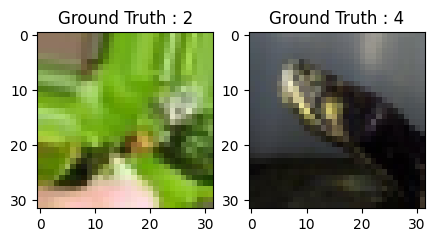

In [ ]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

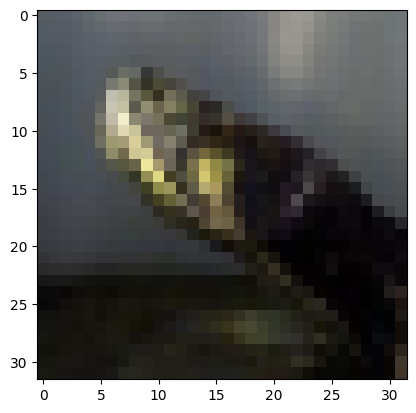

In [ ]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X/255.
test_X = test_X/255.
plt.imshow(test_X[0,:,:])

## Hacemos el One-hot Encoding para la red

In [ ]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 2
After conversion to one-hot: [0. 0. 1. 0. 0.]


# Creamos el Set de Entrenamiento y Validación

In [ ]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [ ]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(33872, 32, 32, 3) (8468, 32, 32, 3) (33872, 5) (8468, 5)


# Creamos el modelo de CNN

In [ ]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 20 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 64 # cantidad de imágenes que se toman a la vez en memoria

In [ ]:
sport_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(nClasses, activation='softmax')
])


c:\Users\Adolfo\Documents\ProyectsVisualStudioCode\Inteligencia Artificial\Entorno Virtual\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
sport_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,557 (623.27 KB)

 Trainable params: 159,557 (623.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
sport_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



# Entrenamos el modelo: Aprende a clasificar imágenes

In [ ]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre
sport_train = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5884 - loss: 0.9554 - val_accuracy: 0.7008 - val_loss: 0.7260
Epoch 2/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7079 - loss: 0.7095 - val_accuracy: 0.7567 - val_loss: 0.6182
Epoch 3/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7535 - loss: 0.6255 - val_accuracy: 0.7760 - val_loss: 0.5757
Epoch 4/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7785 - loss: 0.5737 - val_accuracy: 0.7887 - val_loss: 0.5431
Epoch 5/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7974 - loss: 0.5206 - val_accuracy: 0.7796 - val_loss: 0.5594
Epoch 6/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8135 - loss: 0.4875 - val_accuracy: 0.7915 - val_loss: 0.5224
Epoch 7/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8257 - loss: 0.4527 - val_accuracy: 0.7883 - val_loss: 0.5358
Epoch 8/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8421 - loss: 0.4134 - val_acc

In [ ]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
sport_model.save("animales1.h5")

# Evaluamos la red

In [ ]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)

331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8215 - loss: 0.6634


In [ ]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.6634197235107422
Test accuracy: 0.8215399384498596


In [ ]:
sport_train.history

{'accuracy': [0.5883620977401733,
  0.7079298496246338,
  0.7534837126731873,
  0.7784895896911621,
  0.7974137663841248,
  0.8134742379188538,
  0.8256672024726868,
  0.8420819640159607,
  0.8546292185783386,
  0.8605337738990784,
  0.8759447336196899,
  0.885657787322998,
  0.8991202116012573,
  0.9049362540245056,
  0.9138521552085876,
  0.9225909113883972,
  0.9312115907669067,
  0.9346362948417664,
  0.9417808055877686,
  0.946770191192627],
 'loss': [0.9553869962692261,
  0.7094508409500122,
  0.6255199313163757,
  0.5737200975418091,
  0.5205640196800232,
  0.4874591529369354,
  0.45267724990844727,
  0.4133571982383728,
  0.3820812702178955,
  0.36061492562294006,
  0.32840970158576965,
  0.3046438992023468,
  0.2654487192630768,
  0.2549707889556885,
  0.22920775413513184,
  0.20754729211330414,
  0.18820510804653168,
  0.1725672483444214,
  0.1568290740251541,
  0.1452648937702179],
 'val_accuracy': [0.700755774974823,
  0.7567312121391296,
  0.7759801745414734,
  0.788734078

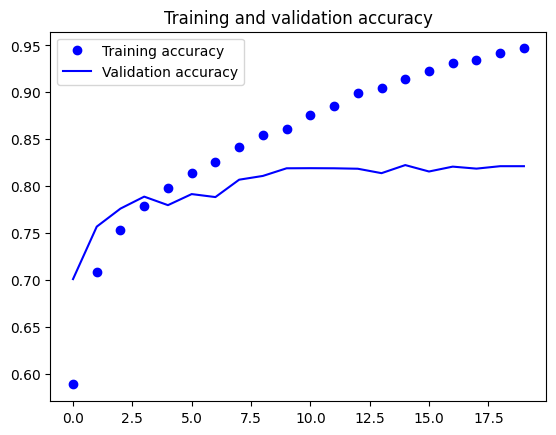

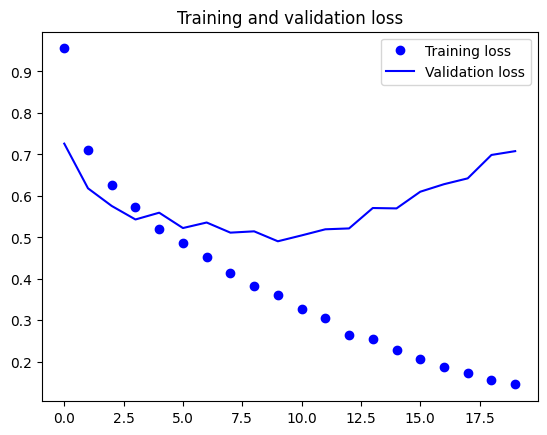

In [ ]:
accuracy = sport_train.history['accuracy']
val_accuracy = sport_train.history['val_accuracy']
loss = sport_train.history['loss']
val_loss = sport_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
predicted_classes2 = sport_model.predict(test_X)

331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [ ]:
predicted_classes.shape, test_Y.shape

((10585,), (10585,))

# Aprendamos de los errores: Qué mejorar

Found 8696 correct labels


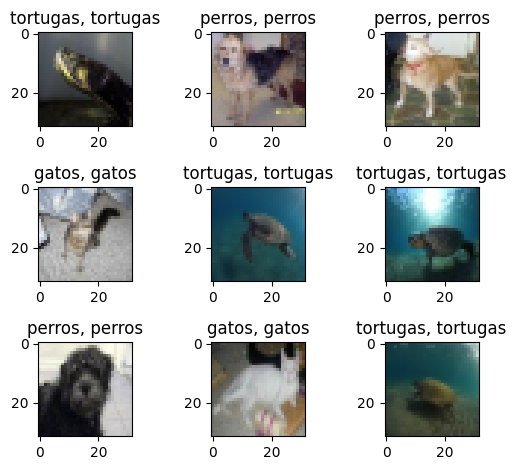

In [ ]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(32,32,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[correct]],
                                                    deportes[test_Y[correct]]))

    plt.tight_layout()

Found 1889 incorrect labels


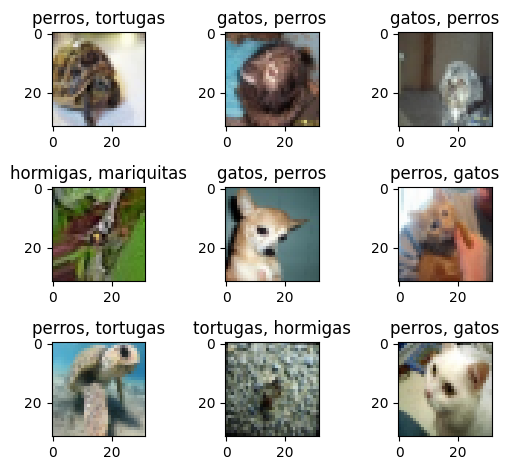

In [ ]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(32,32,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[incorrect]],
                                                    deportes[test_Y[incorrect]]))
    plt.tight_layout()

In [ ]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.79      0.71      0.75      2568
     Class 1       0.84      0.86      0.85      1366
     Class 2       0.87      0.82      0.84      1525
     Class 3       0.71      0.79      0.75      2517
     Class 4       0.94      0.94      0.94      2609

    accuracy                           0.82     10585
   macro avg       0.83      0.82      0.83     10585
weighted avg       0.82      0.82      0.82     10585



In [ ]:
from skimage.transform import resize

images=[]
# AQUI ESPECIFICAMOS UNAS IMAGENES
filenames = ['mariquita prueba 1.jpg']

for filepath in filenames:
    image = plt.imread(filepath,0)
    image_resized = resize(image, (32, 32),anti_aliasing=True,clip=False,preserve_range=True)
    images.append(image_resized)

X = np.array(images, dtype=np.uint8) #convierto de lista a numpy
test_X = X.astype('float32')
test_X = test_X / 255.

predicted_classes = sport_model.predict(test_X)

for i, img_tagged in enumerate(predicted_classes):
    print(filenames[i], deportes[img_tagged.tolist().index(max(img_tagged))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
mariquita prueba 1.jpg mariquitas
